C:\Users\26746\AppData\Local\Temp\ipykernel_21856\1139499456.py:204: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Vehicle Speed')


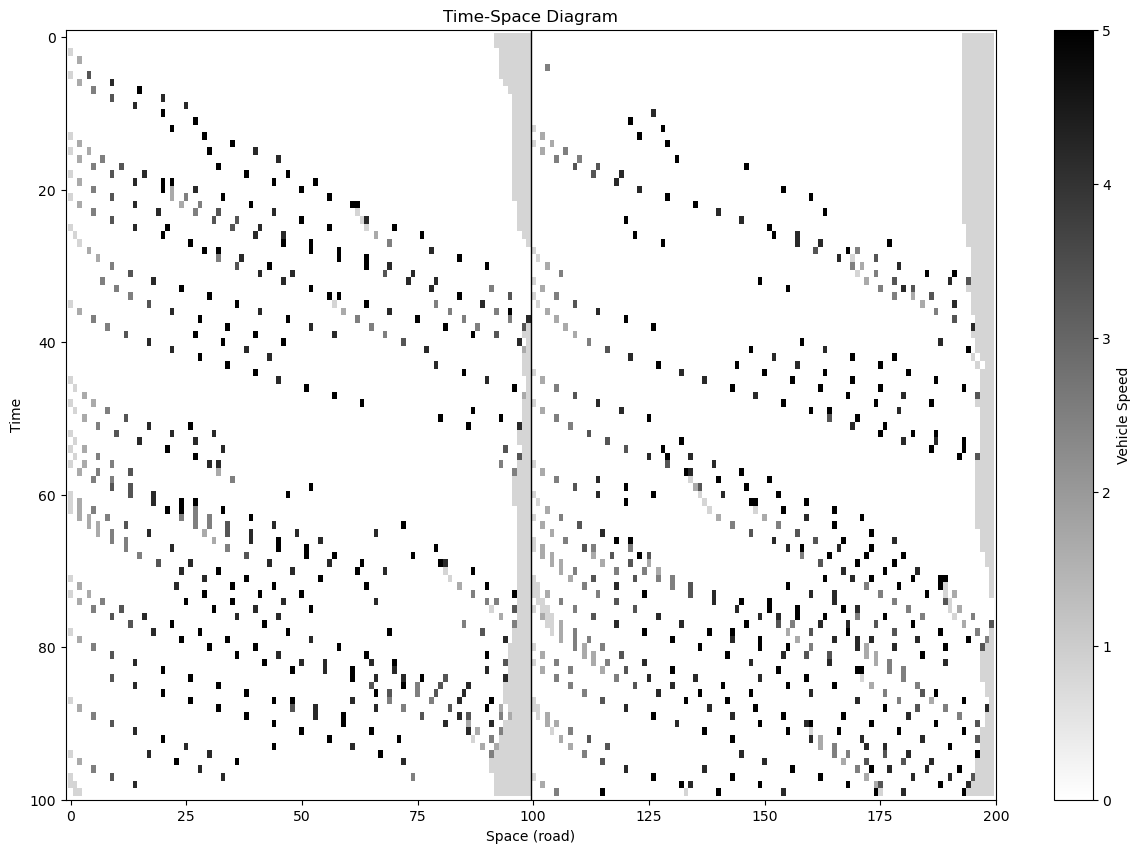

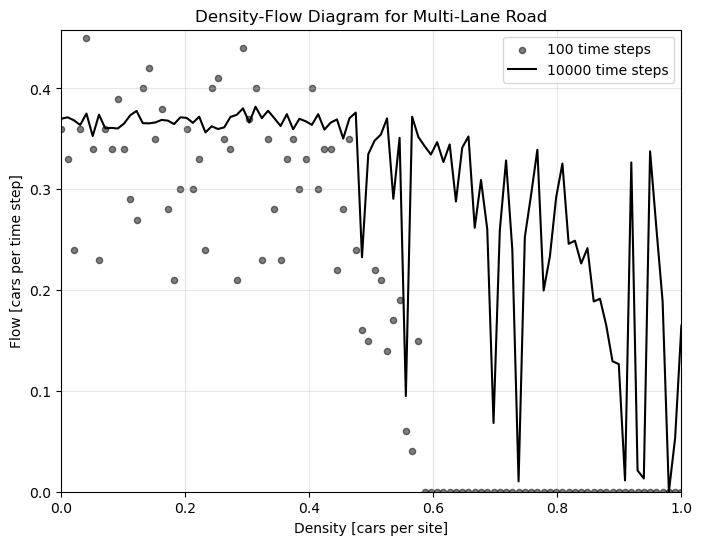

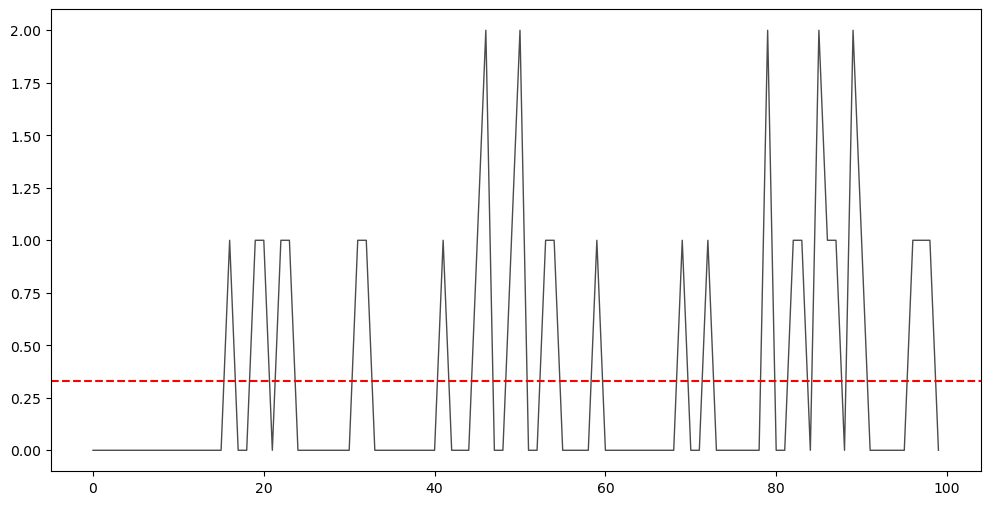

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

np.random.seed(8)

def initialize_road(num_lanes, length, num_cars):
    road = {
        'upper': np.full((length), -1),  
        'lower': np.full((length), -1)   
    }
    
    all_positions = np.random.choice(num_lanes * length, num_cars, replace=False)
    for pos in all_positions:
        lane = pos // length
        road['upper' if lane == 0 else 'lower'][pos % length] = 0  
    return road

def get_distance_to_next_car(lane_data, pos):
    length = len(lane_data)
    for i in range(1, length - pos):
        next_pos = pos + i
        if lane_data[next_pos] != -1:  # Found a car
            return i  # Distance to next car
    return length - pos  # If no car ahead, return maximum distance

def update_road(road, p_enter=0.2, p_exit=0.2):
    # Exit: Check if the car at the last position exits
    for lane in ['upper', 'lower']:
        if road[lane][-1] != -1 and np.random.rand() < p_exit:
            road[lane][-1] = -1  # Last car exits

    # Move cars forward if possible
    for lane in ['upper', 'lower']:
        for i in range(len(road[lane]) - 2, -1, -1):  # Iterate backward
            if road[lane][i] != -1 and road[lane][i + 1] == -1:  # Car moves forward
                road[lane][i + 1] = road[lane][i]
                road[lane][i] = -1  # Vacant the previous spot

    # Entry: New car enters if the first position is empty
    for lane in ['upper', 'lower']:
        if road[lane][0] == -1 and np.random.rand() < p_enter:
            road[lane][0] = 0  # A new car enters

    return road

def check_overtake_conditions(road, current_lane, pos, vmax=5, safe_gap=3, p_change=0.5):
    v_current = road[current_lane][pos]
    
    dist_front = get_distance_to_next_car(road[current_lane], pos)
    if dist_front <= safe_gap:
        return None  # Too small distance, cannot overtake
    
    v_front = road[current_lane][pos + dist_front] if pos + dist_front < len(road[current_lane]) else -1
    if v_front != -1 and v_front >= v_current:
        return None  # Front car is moving faster, cannot overtake
    
    # Enough space in adjacent lane
    target_lane = 'upper' if current_lane == 'lower' else 'lower'
    gap_adjacent = get_distance_to_next_car(road[target_lane], pos)
    if gap_adjacent <= safe_gap:
        return None  # Too small gap in adjacent lane
    
    #  p_change: probability of changing lanes
    if np.random.rand() > p_change:
        return None  # Probability check to change lane
    
    return target_lane  # Overtake possible

def update_lane_change(road, current_lane, pos, target_lane, v_current,vmax=5, safe_gap=3):
    length = len(road[current_lane])
    
    if road[target_lane][pos] == -1:
        road[target_lane][pos] = v_current  # lane change,maintain velocity
        road[current_lane][pos] = -1
    return road

    gap_adjacent = get_distance_to_next_car(road[target_lane], pos)
    v_change = min(v_current, gap_adjacent - 1)

    new_pos = pos + v_change
    if new_pos >= length:
        return 
    if new_road[lane][new_pos] == -1:
        new_road[lane][new_pos] = v
        
    if new_pos < length and road[target_lane][new_pos] == -1:  # Position valid and empty
        road[target_lane][new_pos] = v_change
        road[current_lane][pos] = -1  # Move car to new lane
    return road

def update_traffic_with_overtake(road, vmax=5, p=0.3, safe_gap=3, p_change=0.5):
    new_road = {
        'upper': np.full_like(road['upper'], -1),
        'lower': np.full_like(road['lower'], -1)
    }
    
    for lane in ['upper', 'lower']:
        length = len(road[lane])
        
        for pos in range(length - 1, -1, -1):  # Iterate backward
            if road[lane][pos] == -1:
                continue
            v = road[lane][pos]
            v = min(v + 1, vmax)  # Speed increase, limited by vmax
            
            dist = get_distance_to_next_car(road[lane], pos)
            v = min(v, dist - 1)  # Adjust speed based on distance to next car
            
            if np.random.rand() < p and v > 0:  # Chance of slowing down
                v -= 1
            
            # Overtake check
            target_lane = check_overtake_conditions(road, lane, pos, vmax, safe_gap, p_change)
            if target_lane is not None:
                new_road = update_lane_change(new_road, lane, pos, target_lane, v)
            else:
                # Move car to new position
                new_pos = pos + v
                if new_road[lane][new_pos] == -1:
                    new_road[lane][new_pos] = v
                else:
                    new_road[lane][pos] = v  # Stay in current lane if no space

    return new_road

def calculate_traffic_measurements(road):
    num_lanes, length = len(road['upper']), len(road['upper'])
    num_cars = np.sum(np.array([road['upper'], road['lower']]) != -1)
    density = num_cars / (num_lanes * length)
    speeds = np.concatenate([road['upper'][road['upper'] != -1], road['lower'][road['lower'] != -1]])
    avg_velocity = np.mean(speeds) if len(speeds) > 0 else 0
    flow = 0
    for lane in ['upper', 'lower']:
        for pos in range(length):
            if road[lane][pos] != -1:
                velocity = road[lane][pos]
                start_pos = max(0, pos - velocity)
                if start_pos <= length // 2 < pos:
                    flow += 1
    return flow, density, avg_velocity

def run_simulation_multi_lane(num_lanes, length, num_cars, t0, steps, vmax=5, p=0.3, safe_gap=3, p_change=0.5, p_enter=0.2, p_exit=0.2):
    road = initialize_road(num_lanes, length, num_cars)
   
    # first run the code t0 times, and begin the collection of data after the first t0 time steps
    for i in range(t0):
        road = update_traffic_with_overtake(road, vmax, p, safe_gap, p_change)
        
    flows = []
    densities = []
    avg_velocities = []
    
    road_matrix = np.zeros((steps, num_lanes, length), dtype=int)
    road_matrix[0] = np.vstack([road['upper'], road['lower']])    # Store initial state
    
    for step in range(steps):
        road = update_traffic_with_overtake(road, vmax, p, safe_gap, p_change)
        road = update_road(road, p_enter, p_exit)
        
        if step < steps - 1:
            road_matrix[step + 1] = np.vstack([road['upper'], road['lower']])
            
        flow, density, avg_velocity = calculate_traffic_measurements(road)
        flows.append(flow)
        densities.append(density)
        avg_velocities.append(avg_velocity)
    
    return np.array(flows), np.array(densities), np.array(avg_velocities), road_matrix


def plot_space_time_diagram_multi_lane(road_matrix):
    steps, num_lanes, length = road_matrix.shape
    
    # Create a 2D array for visualization where we will represent vehicles using their speed as color
    space_time_diagram = np.full((steps, length * num_lanes), -1, dtype=int)

    for i in range(steps):
        for lane in range(num_lanes):
            space_time_diagram[i, lane * length:(lane + 1) * length] = road_matrix[i, lane, :]

    # visualize the diagram
    plt.figure(figsize=(15, 10))  

    # Use a color map to represent vehicle speeds
    cmap = 'binary'# plt.cm.viridis  # Or you can use any other colormap you like
    plt.imshow(space_time_diagram, cmap=cmap, aspect='auto', interpolation='nearest')

    # Add vertical lines to separate the lanes
    for lane in range(1, num_lanes):
        plt.axvline(x=lane * length - 0.5, color='black', linewidth=1)  # Vertical line between lanes

    # Adjust the limits 
    plt.xlim(-1, length * num_lanes)
    plt.ylim(steps, -1)
    
    plt.xlabel('Space (road)')
    plt.ylabel('Time')
    plt.title('Time-Space Diagram')

    # Add a color bar to indicate vehicle speed (optional)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=np.max(road_matrix)))
    sm.set_array([])
    plt.colorbar(sm, label='Vehicle Speed')

    plt.show()

# Example usage: Run simulation and plot space-time diagram
flows, densities, velocities, road_matrix = run_simulation_multi_lane(num_lanes=2, length=100, num_cars=20, t0=1000, steps=100)

plot_space_time_diagram_multi_lane(road_matrix)



def simulate_multiple_densities_multi_lane(road_length=100, steps=100, steps_long=10000, num_lanes=2):
    densities = np.linspace(0, 1, 100)  # Vary density from 0 to 1 car per site
    flows_short = []
    flows_long = []

    for density in densities:
        num_cars = int(density * road_length * num_lanes)    
    
        
        # short-term
        flows,_, _, _ = run_simulation_multi_lane(num_lanes, road_length, num_cars, 100, steps)
        flows_short.append(np.mean(flows))
        
        
        # long-term
        flows,_, _, _ = run_simulation_multi_lane(num_lanes, road_length, num_cars, 100, steps_long)
        flows_long.append(np.mean(flows))
        

    # plot figure
    plt.figure(figsize=(8, 6))
    plt.scatter(densities, flows_short, alpha=0.5, s=20, color='black', label='100 time steps')
    plt.plot(densities, flows_long, '-', color='black', label='10000 time steps')

    plt.xlabel('Density [cars per site]')
    plt.ylabel('Flow [cars per time step]')
    plt.title('Density-Flow Diagram for Multi-Lane Road')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, max(flows_long) * 1.2 if max(flows_long) > 0 else 1)


    plt.legend()
    plt.show()


simulate_multiple_densities_multi_lane()

# code for flow-time plot
def plot_flow_time_multi_lane(num_lanes, length, num_cars, t0, steps, vmax, p):
    flows, _, velocities, road_matrix = run_simulation_multi_lane(num_lanes, length, num_cars, t0, steps, vmax, p)
    time = np.arange(steps)
    plt.figure(figsize=(12, 6))
    plt.plot(time, flows, 'k-', linewidth=1, alpha=0.7)
    plt.axhline(y=np.mean(flows), color='r', linestyle='--', 
                label=f'Mean flow: {np.mean(flows):.3f}')

    plt.show()
    
plot_flow_time_multi_lane(num_lanes=2, length=100, num_cars=20, t0 = 10000, steps=100, vmax=5, p=0.2)